In [2]:
# !pip install pandas
!pip install numpy

In [3]:
!pip install pygad

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('QS_WUR_Graphs_With_DataLabels(Аркуш2).csv', delimiter=';')
df

,University,Year,Academic Reputation (AR),Employer Reputation (ER),Faculty Student Ratio (FSR),Citations per Faculty (CPF),International Faculty Ratio (IFR),International Student Ratio (ISR),International Research Network (IRN),Employment Outcomes (GER),Sustainability (SUS)
0,"National Technical University ""Kharkiv Polytec...",2025,"6,5","10,6","54,3","1,3","1,7","20,1","11,4",4,"1,6"


$F(\mathbf{x}) =
0.30 \cdot AR +
0.15 \cdot ER +
0.10 \cdot FSR +
0.20 \cdot CPF +
0.05 \cdot IFR +
0.05 \cdot ISR +
0.05 \cdot IRN +
0.05 \cdot EO +
0.05 \cdot SUS $

In [6]:
WEIGHTS = {
    "Academic Reputation (AR)": 0.30,
    "Employer Reputation (ER)": 0.15,
    "Faculty Student Ratio (FSR)": 0.10,
    "Citations per Faculty (CPF)": 0.20,
    "International Faculty Ratio (IFR)": 0.05,
    "International Student Ratio (ISR)": 0.05,
    "International Research Network (IRN)": 0.05,
    "Employment Outcomes (GER)": 0.05,
    "Sustainability (SUS)": 0.05
}

In [7]:
def compute_overall_score(df: pd.DataFrame) -> pd.DataFrame:
    overall_scores = []

    for _, row in df.iterrows():
        score = 0.0
        for col, weight in WEIGHTS.items():
            value = row.get(col)
            if pd.notna(value):
                try:
                    value_float = float(str(value).replace(',', '.'))
                    score += value_float * weight
                except ValueError:
                    pass
        overall_scores.append(score)

    df["Overall Score"] = overall_scores
    return df

compute_overall_score(df)

,University,Year,Academic Reputation (AR),Employer Reputation (ER),Faculty Student Ratio (FSR),Citations per Faculty (CPF),International Faculty Ratio (IFR),International Student Ratio (ISR),International Research Network (IRN),Employment Outcomes (GER),Sustainability (SUS),Overall Score
0,"National Technical University ""Kharkiv Polytec...",2025,"6,5","10,6","54,3","1,3","1,7","20,1","11,4",4,"1,6",11.17


In [8]:
import pygad
import numpy as np
import pandas as pd

# Поточні значення ХПІ за 2025 рік
x_2025 = {
    "AR": 6.5,
    "ER": 10.6,
    "FSR": 54.3,
    "CPF": 1.3,
    "IFR": 1.7,
    "ISR": 20.1,  # freeze
    "IRN": 11.4,
    "EO": 4.0,
    "SUS": 1.6
}

weights = {
    "AR": 0.30,
    "ER": 0.15,
    "FSR": 0.10,
    "CPF": 0.20,
    "IFR": 0.05,
    "ISR": 0.05,
    "IRN": 0.05,
    "EO": 0.05,
    "SUS": 0.05
}

max_value = {
    "AR": 15,
    "ER": 20,
    "FSR": 70,
    "CPF": 3,
    "IFR": 12,
    "ISR": 20,
    "IRN": 30,
    "EO": 15,
    "SUS": 10
}

max_increase = {
    "AR": 1.0,
    "ER": 1.0,
    "FSR": 1.0,
    "CPF": 0.3,
    "IFR": 2.0,
    "ISR": 0.0,
    "IRN": 5.0,
    "EO": 2.0,
    "SUS": 1.0
}

resource_cost = {
    "AR": 100,
    "ER": 90,
    "FSR": 40,
    "CPF": 30,
    "IFR": 60,
    "ISR": float("inf"),
    "IRN": 20,
    "EO": 20,
    "SUS": 10
}

def compute_qs_score(x):
    return sum(x[i] * w for i, w in enumerate(weights.values()))

def fitness_func(ga_instance, solution, solution_idx):
    keys = list(x_2025.keys())
    x_new = dict(zip(keys, solution))
    total_ru = 0
    details = []

    for k in keys:
        prev = x_2025[k]
        curr = x_new[k]
        delta = curr - prev

        if resource_cost[k] == float("inf"):
            if delta != 0:
                return -10000
        else:
            if delta > 0:
                cost = resource_cost[k] * delta
                total_ru += cost
                details.append((k, prev, curr, delta, resource_cost[k], cost))
                
    if ga_instance.generations_completed % 10 == 0:
        print(f"\n[Generation {ga_instance.generations_completed}]")
        print(f"Total RU used: {total_ru:.2f}")
        print("Details:")
        for d in details:
            print(f"  {d[0]}: {d[1]:.2f} → {d[2]:.2f} (Δ={d[3]:.2f}) × {d[4]} = {d[5]:.2f}")
        print(f"QS Score: {compute_qs_score(solution):.2f}")

    if total_ru > 200:
        return -1000 * (total_ru - 200)

    return compute_qs_score(solution)

gene_space = []
for k in x_2025.keys():
    low = x_2025[k]
    if max_increase[k] == 0:
        gene_space.append([low])
    else:
        high = min(x_2025[k] + max_increase[k], max_value[k])
        gene_space.append({"low": low, "high": high, "step": 0.1})
    
# Запуск GA
ga_instance = pygad.GA(
    num_generations=500,
    num_parents_mating=20,
    fitness_func=fitness_func,
    sol_per_pop=45,
    num_genes=9,
    gene_space=gene_space,
    mutation_percent_genes=20,
    mutation_type="random",
    random_mutation_min_val=0,
    random_mutation_max_val=1,
    stop_criteria="saturate_10"
)

ga_instance.run()

solution, qs_score, _ = ga_instance.best_solution()
x_2026 = dict(zip(x_2025.keys(), solution))

print("\nНайкраще рішення на 2026 рік:")
for k in x_2026:
    print(f"{k}: {x_2026[k]:.2f} (було: {x_2025[k]:.2f})")

print(f"\nQS Overall Score (2026): {qs_score:.2f}")

result_df = pd.DataFrame({
    "Показник": x_2025.keys(),
    "2025": x_2025.values(),
    "2026 (оптимізовано)": solution,
    "Приріст": [solution[i] - list(x_2025.values())[i] for i in range(9)]
})

print("\n", result_df)


[Generation 0]
Total RU used: 251.00
Details:
  AR: 6.50 → 6.90 (Δ=0.40) × 100 = 40.00
  ER: 10.60 → 11.40 (Δ=0.80) × 90 = 72.00
  FSR: 54.30 → 54.50 (Δ=0.20) × 40 = 8.00
  CPF: 1.30 → 1.60 (Δ=0.30) × 30 = 9.00
  IFR: 1.70 → 2.80 (Δ=1.10) × 60 = 66.00
  IRN: 11.40 → 13.70 (Δ=2.30) × 20 = 46.00
  EO: 4.00 → 4.50 (Δ=0.50) × 20 = 10.00
QS Score: 11.68

[Generation 0]
Total RU used: 367.00
Details:
  AR: 6.50 → 7.00 (Δ=0.50) × 100 = 50.00
  ER: 10.60 → 11.40 (Δ=0.80) × 90 = 72.00
  FSR: 54.30 → 55.20 (Δ=0.90) × 40 = 36.00
  CPF: 1.30 → 1.40 (Δ=0.10) × 30 = 3.00
  IFR: 1.70 → 3.40 (Δ=1.70) × 60 = 102.00
  IRN: 11.40 → 15.10 (Δ=3.70) × 20 = 74.00
  EO: 4.00 → 5.30 (Δ=1.30) × 20 = 26.00
  SUS: 1.60 → 2.00 (Δ=0.40) × 10 = 4.00
QS Score: 11.90

[Generation 0]
Total RU used: 203.00
Details:
  AR: 6.50 → 7.20 (Δ=0.70) × 100 = 70.00
  ER: 10.60 → 11.20 (Δ=0.60) × 90 = 54.00
  CPF: 1.30 → 1.60 (Δ=0.30) × 30 = 9.00
  IFR: 1.70 → 2.10 (Δ=0.40) × 60 = 24.00
  IRN: 11.40 → 12.40 (Δ=1.00) × 20 = 20.00


In [9]:
from pprint import pprint

print("\nGene Space для кожного показника:")
pprint(gene_space)


Gene Space для кожного показника:
[{'high': 7.5, 'low': 6.5, 'step': 0.1},
 {'high': 11.6, 'low': 10.6, 'step': 0.1},
 {'high': 55.3, 'low': 54.3, 'step': 0.1},
 {'high': 1.6, 'low': 1.3, 'step': 0.1},
 {'high': 3.7, 'low': 1.7, 'step': 0.1},
 [20.1],
 {'high': 16.4, 'low': 11.4, 'step': 0.1},
 {'high': 6.0, 'low': 4.0, 'step': 0.1},
 {'high': 2.6, 'low': 1.6, 'step': 0.1}]


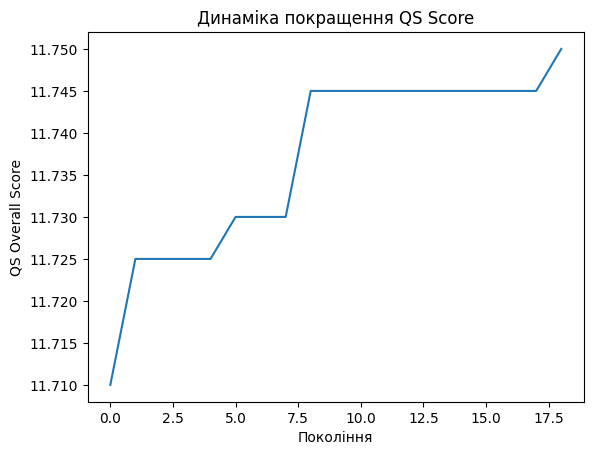

In [10]:
import matplotlib.pyplot as plt

plt.plot(ga_instance.best_solutions_fitness)
plt.xlabel("Покоління")
plt.ylabel("QS Overall Score")
plt.title("Динаміка покращення QS Score")
plt.show()

In [11]:
!pip install scipy

In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import pygad

# === Базові дані === #
x_2025 = {
    "AR": 6.5,
    "ER": 10.6,
    "FSR": 54.3,
    "CPF": 1.3,
    "IFR": 1.7,
    "ISR": 20.1,  # freeze
    "IRN": 11.4,
    "EO": 4.0,
    "SUS": 1.6
}

weights = {
    "AR": 0.30, "ER": 0.15, "FSR": 0.10, "CPF": 0.20,
    "IFR": 0.05, "ISR": 0.05, "IRN": 0.05, "EO": 0.05, "SUS": 0.05
}

max_value = {
    "AR": 15, "ER": 20, "FSR": 70, "CPF": 3,
    "IFR": 12, "ISR": 20, "IRN": 30, "EO": 15, "SUS": 10
}

max_increase = {
    "AR": 1.0, "ER": 1.0, "FSR": 1.0, "CPF": 0.3,
    "IFR": 2.0, "ISR": 0.0, "IRN": 5.0, "EO": 2.0, "SUS": 1.0
}

resource_cost = {
    "AR": 100, "ER": 90, "FSR": 40, "CPF": 30,
    "IFR": 60, "ISR": float("inf"), "IRN": 20, "EO": 20, "SUS": 10
}


# === Функція LP (лінійне програмування) === #
def optimize_qs_lp(selected_indicators, RU_budget=200):
    keys = list(x_2025.keys())
    deltas = []
    costs = []
    bounds = []

    for k in keys:
        if k in selected_indicators and max_increase[k] > 0:
            deltas.append(weights[k])
            costs.append(resource_cost[k])
            bounds.append((0, max_increase[k]))
        else:
            deltas.append(0)
            costs.append(0)
            bounds.append((0, 0))

    res = linprog(
        c=[-w for w in deltas],  # мінімізуємо, тому ставимо -
        A_ub=[costs],
        b_ub=[RU_budget],
        bounds=bounds,
        method="highs"
    )

    if res.success:
        solution = res.x
        x_2026 = {k: x_2025[k] + solution[i] for i, k in enumerate(keys)}
        qs_score = sum(x_2026[k] * weights[k] for k in keys)
        df = pd.DataFrame({
            "Показник": keys,
            "2025": [x_2025[k] for k in keys],
            "2026 (оптимізовано)": [x_2026[k] for k in keys],
            "Приріст": solution
        })
        return x_2026, qs_score, df
    else:
        raise RuntimeError("LP optimization failed")


def optimize_qs_ga(selected_indicators, RU_budget=200):

    def compute_qs_score(x):
        return sum(x[i] * w for i, w in enumerate(weights.values()))

    def fitness_func(ga_instance, solution, solution_idx):
        keys = list(x_2025.keys())
        x_new = dict(zip(keys, solution))
        total_ru = 0

        for k in keys:
            prev = x_2025[k]
            curr = x_new[k]
            delta = curr - prev

            if k not in selected_indicators:
                if abs(delta) > 1e-6:
                    return -10000
                continue

            if resource_cost[k] == float("inf"):
                if delta != 0:
                    return -10000
            else:
                if delta > 0:
                    total_ru += resource_cost[k] * delta

        if total_ru > RU_budget:
            return -1000 * (total_ru - RU_budget)

        return compute_qs_score(solution)

    gene_space = []
    for k in x_2025.keys():
        low = x_2025[k]
        if k not in selected_indicators or max_increase[k] == 0:
            gene_space.append([low])
        else:
            high = min(x_2025[k] + max_increase[k], max_value[k])
            gene_space.append({"low": low, "high": high, "step": 0.1})

    ga_instance = pygad.GA(
        num_generations=500,
        num_parents_mating=20,
        fitness_func=fitness_func,
        sol_per_pop=45,
        num_genes=len(x_2025),
        gene_space=gene_space,
        mutation_percent_genes=20,
        mutation_type="random",
        random_mutation_min_val=0,
        random_mutation_max_val=1,
        stop_criteria="saturate_30"
    )

    ga_instance.run()
    solution, qs_score, _ = ga_instance.best_solution()
    x_2026 = dict(zip(x_2025.keys(), solution))

    df = pd.DataFrame({
        "Показник": list(x_2025.keys()),
        "2025": x_2025.values(),
        "2026 (оптимізовано)": solution,
        "Приріст": [solution[i] - list(x_2025.values())[i] for i in range(len(x_2025))]
    })

    return x_2026, qs_score, df

In [13]:
x_2026_lp, score_lp, df_lp = optimize_qs_lp(["AR", "FSR"])
print(df_lp)
print("QS Score (LP):", score_lp)

x_2026_ga, score_ga, df_ga = optimize_qs_ga(["AR", "FSR"])
print(df_ga)
print("QS Score (GA):", score_ga)

  Показник  2025  2026 (оптимізовано)  Приріст
0       AR   6.5                  7.5      1.0
1       ER  10.6                 10.6      0.0
2      FSR  54.3                 55.3      1.0
3      CPF   1.3                  1.3      0.0
4      IFR   1.7                  1.7      0.0
5      ISR  20.1                 20.1      0.0
6      IRN  11.4                 11.4      0.0
7       EO   4.0                  4.0      0.0
8      SUS   1.6                  1.6      0.0
QS Score (LP): 11.570000000000002
  Показник  2025  2026 (оптимізовано)  Приріст
0       AR   6.5                  7.4      0.9
1       ER  10.6                 10.6      0.0
2      FSR  54.3                 55.2      0.9
3      CPF   1.3                  1.3      0.0
4      IFR   1.7                  1.7      0.0
5      ISR  20.1                 20.1      0.0
6      IRN  11.4                 11.4      0.0
7       EO   4.0                  4.0      0.0
8      SUS   1.6                  1.6      0.0
QS Score (GA): 11.53000000

In [14]:
!pip install pulp

In [15]:
import pulp
import pandas as pd

def optimize_qs_pulp(selected_indicators, RU_budget=200):
    keys = list(x_2025.keys())

    # Модель (максимізація)
    model = pulp.LpProblem("QS_Optimization", pulp.LpMaximize)

    # Змінні: k_i — скільки разів взяли приріст по 0.1
    k_vars = {}
    for k in keys:
        if k in selected_indicators and max_increase[k] > 0 and resource_cost[k] < float("inf"):
            k_vars[k] = pulp.LpVariable(f"k_{k}", lowBound=0, upBound=int(max_increase[k] / 0.1), cat="Integer")
        else:
            # фіксуємо на 0
            k_vars[k] = pulp.LpVariable(f"k_{k}", lowBound=0, upBound=0, cat="Integer")
    
    print(k_vars)

    # Цільова функція: максимізуємо QS Score
    model += pulp.lpSum([
        weights[k] * (x_2025[k] + 0.1 * k_vars[k]) for k in keys
    ])

    # Обмеження по ресурсах (лише для показників із finite cost)
    model += pulp.lpSum([
        resource_cost[k] * 0.1 * k_vars[k] for k in keys if resource_cost[k] < float("inf")
    ]) <= RU_budget
    
    print(model)
    # Розв’язуємо
    model.solve(pulp.PULP_CBC_CMD(msg=0))

    # Результати
    deltas = {k: 0.1 * pulp.value(k_vars[k]) for k in keys}
    x_2026 = {k: x_2025[k] + deltas[k] for k in keys}
    qs_score = sum(x_2026[k] * weights[k] for k in keys)

    df = pd.DataFrame({
        "Показник": keys,
        "2025": [x_2025[k] for k in keys],
        "2026 (оптимізовано)": [x_2026[k] for k in keys],
        "Приріст": [deltas[k] for k in keys],
        "Витрати RU": [deltas[k] * resource_cost[k] if resource_cost[k] < float("inf") else 0 for k in keys]
    })

    return x_2026, qs_score, df

In [16]:
x_2026, score, df = optimize_qs_pulp(["AR", "ER"], RU_budget=200)

print(df)
print("QS Score (PuLP):", score)

{'AR': k_AR, 'ER': k_ER, 'FSR': k_FSR, 'CPF': k_CPF, 'IFR': k_IFR, 'ISR': k_ISR, 'IRN': k_IRN, 'EO': k_EO, 'SUS': k_SUS}
QS_Optimization:
MAXIMIZE
0.03*k_AR + 0.020000000000000004*k_CPF + 0.005000000000000001*k_EO + 0.015*k_ER + 0.010000000000000002*k_FSR + 0.005000000000000001*k_IFR + 0.005000000000000001*k_IRN + 0.005000000000000001*k_ISR + 0.005000000000000001*k_SUS + 11.17
SUBJECT TO
_C1: 10 k_AR + 3 k_CPF + 2 k_EO + 9 k_ER + 4 k_FSR + 6 k_IFR + 2 k_IRN + k_SUS
 <= 200

VARIABLES
0 <= k_AR <= 10 Integer
k_CPF = 0 Integer
k_EO = 0 Integer
0 <= k_ER <= 10 Integer
k_FSR = 0 Integer
k_IFR = 0 Integer
k_IRN = 0 Integer
k_ISR = 0 Integer
k_SUS = 0 Integer

  Показник  2025  2026 (оптимізовано)  Приріст  Витрати RU
0       AR   6.5                  7.5      1.0       100.0
1       ER  10.6                 11.6      1.0        90.0
2      FSR  54.3                 54.3      0.0         0.0
3      CPF   1.3                  1.3      0.0         0.0
4      IFR   1.7                  1.7     

In [17]:
x_2026, score, df = optimize_qs_pulp(["AR", "ER", "FSR"], RU_budget=200)

print(df)
print("QS Score (PuLP):", score)

{'AR': k_AR, 'ER': k_ER, 'FSR': k_FSR, 'CPF': k_CPF, 'IFR': k_IFR, 'ISR': k_ISR, 'IRN': k_IRN, 'EO': k_EO, 'SUS': k_SUS}
QS_Optimization:
MAXIMIZE
0.03*k_AR + 0.020000000000000004*k_CPF + 0.005000000000000001*k_EO + 0.015*k_ER + 0.010000000000000002*k_FSR + 0.005000000000000001*k_IFR + 0.005000000000000001*k_IRN + 0.005000000000000001*k_ISR + 0.005000000000000001*k_SUS + 11.17
SUBJECT TO
_C1: 10 k_AR + 3 k_CPF + 2 k_EO + 9 k_ER + 4 k_FSR + 6 k_IFR + 2 k_IRN + k_SUS
 <= 200

VARIABLES
0 <= k_AR <= 10 Integer
k_CPF = 0 Integer
k_EO = 0 Integer
0 <= k_ER <= 10 Integer
0 <= k_FSR <= 10 Integer
k_IFR = 0 Integer
k_IRN = 0 Integer
k_ISR = 0 Integer
k_SUS = 0 Integer

  Показник  2025  2026 (оптимізовано)  Приріст  Витрати RU
0       AR   6.5                  7.5      1.0       100.0
1       ER  10.6                 11.3      0.7        63.0
2      FSR  54.3                 55.2      0.9        36.0
3      CPF   1.3                  1.3      0.0         0.0
4      IFR   1.7                  1

In [18]:
x_2026, qs_score, df = optimize_qs_pulp(
    selected_indicators=list(x_2025.keys()),
    RU_budget=200
)

{'AR': k_AR, 'ER': k_ER, 'FSR': k_FSR, 'CPF': k_CPF, 'IFR': k_IFR, 'ISR': k_ISR, 'IRN': k_IRN, 'EO': k_EO, 'SUS': k_SUS}
QS_Optimization:
MAXIMIZE
0.03*k_AR + 0.020000000000000004*k_CPF + 0.005000000000000001*k_EO + 0.015*k_ER + 0.010000000000000002*k_FSR + 0.005000000000000001*k_IFR + 0.005000000000000001*k_IRN + 0.005000000000000001*k_ISR + 0.005000000000000001*k_SUS + 11.17
SUBJECT TO
_C1: 10 k_AR + 3 k_CPF + 2 k_EO + 9 k_ER + 4 k_FSR + 6 k_IFR + 2 k_IRN + k_SUS
 <= 200

VARIABLES
0 <= k_AR <= 10 Integer
0 <= k_CPF <= 2 Integer
0 <= k_EO <= 20 Integer
0 <= k_ER <= 10 Integer
0 <= k_FSR <= 10 Integer
0 <= k_IFR <= 20 Integer
0 <= k_IRN <= 50 Integer
k_ISR = 0 Integer
0 <= k_SUS <= 10 Integer



In [19]:
x_2026

{'AR': 7.5,
 'ER': 10.6,
 'FSR': 55.3,
 'CPF': 1.5,
 'IFR': 1.7,
 'ISR': 20.1,
 'IRN': 13.600000000000001,
 'EO': 4.0,
 'SUS': 2.6}

In [20]:
df

,Показник,2025,2026 (оптимізовано),Приріст,Витрати RU
0,AR,6.5,7.5,1.0,100.0
1,ER,10.6,10.6,0.0,0.0
2,FSR,54.3,55.3,1.0,40.0
3,CPF,1.3,1.5,0.2,6.0
4,IFR,1.7,1.7,0.0,0.0
5,ISR,20.1,20.1,0.0,0.0
6,IRN,11.4,13.6,2.2,44.0
7,EO,4.0,4.0,0.0,0.0
8,SUS,1.6,2.6,1.0,10.0


In [21]:
qs_score

11.77